# Evaluation of a selection of models on 60km -> 2.2km-4x over Birmingham

In [ ]:
%reload_ext autoreload

%autoreload 2

%reload_ext dotenv
%dotenv

import functools
import math
import string

import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from mlde_analysis.data import prep_eval_data
from mlde_analysis import plot_map, SUBREGIONS
from mlde_analysis.ccs import compute_changes, plot_changes, plot_tp_fd, plot_hist_per_tp
from mlde_analysis.distribution import normalized_mean_bias, normalized_std_bias, plot_freq_density, plot_mean_biases, plot_std_biases, rms_mean_bias, rms_std_bias, compute_metrics, DIST_THRESHOLDS
from mlde_analysis.wet_dry import threshold_exceeded_prop_stats, threshold_exceeded_prop_change, plot_threshold_exceedence_errors, THRESHOLDS
from mlde_analysis.display import VAR_RANGES, pretty_table
from mlde_utils import cp_model_rotated_pole, TIME_PERIODS

In [ ]:
matplotlib.rcParams['figure.dpi'] = 300

In [ ]:
from mlde_analysis.default_params import *

In [ ]:
IPython.display.Markdown(desc)


Describe in more detail the models being compared


In [ ]:
EVAL_DS, MODELS = prep_eval_data(sample_configs, dataset_configs, derived_variables_config, eval_vars, split, ensemble_members=ensemble_members, samples_per_run=samples_per_run)
EVAL_DS

{'CPM': <xarray.Dataset>
 Dimensions:                     (ensemble_member: 1, time: 108,
                                  grid_latitude: 64, grid_longitude: 64,
                                  model: 2, sample_id: 3, bnds: 2)
 Coordinates:
   * ensemble_member             (ensemble_member) object '01'
   * time                        (time) object 1982-09-30 12:00:00 ... 2080-05...
     season                      (time) int64 3 3 3 3 3 3 2 2 ... 1 1 2 2 2 1 1 1
   * grid_latitude               (grid_latitude) float32 -2.49 -2.41 ... 2.55
   * grid_longitude              (grid_longitude) float32 357.9 358.0 ... 363.0
     height                      (time) float64 1.5 1.5 1.5 1.5 ... 1.5 1.5 1.5
   * model                       (model) object 'sa-cCPM' 'mv-cCPM'
     time_period                 (time) <U8 'historic' 'historic' ... 'future'
     dec_adjusted_year           (time) int64 1982 1982 1982 ... 2080 2080 2080
     stratum                     (time) <U12 'historic SON' ... 

In [ ]:
CPM_DAS = { var: EVAL_DS["CPM"][f"target_{var}"] for var in eval_vars }

MODELLABEL2SPEC = { model: {"source": source} | spec for source, models in MODELS.items() for model, spec in models.items() }

In [ ]:
PRED_DAS = { var: xr.concat([ ds[f"pred_{var}"] for ds in EVAL_DS.values() ], dim="model") for var in eval_vars }

In [ ]:
CCS_SEASONS = ["DJF", "JJA"]

In [ ]:
CCS_MODELS = {source: {model: spec for model, spec in mconfigs.items() if spec.get("CCS", False)} for source, mconfigs in MODELS.items() }

CCS_PRED_DAS = {var: PRED_DAS[var].sel(model=list([model for source, models in CCS_MODELS.items() for model in models])) for var in eval_vars }

CCS_DS = xr.combine_by_coords([*list(CPM_DAS.values()), *list(CCS_PRED_DAS.values())])

## Figure: per Time Period per season distribution

* Frequency Density Histogram of rainfall intensities for each time period

Target max: 58.29104232788086
mv-cCPM max: 85.72996520996094
sa-GCM max: 90.74872589111328
sa-cCPM max: 81.28704071044922
2.712673611111111e-05
5e-06
Target max: 61.82958221435547
mv-cCPM max: 64.90055847167969
sa-GCM max: 98.4481201171875
sa-cCPM max: 57.65515899658203
2.712673611111111e-05
5e-06
Target max: 25.84039878845215
mv-cCPM max: 34.21611404418945
sa-GCM max: 48.610870361328125
sa-cCPM max: 54.8906135559082
2.712673611111111e-05
5e-06
Target max: 86.8423843383789
mv-cCPM max: 133.56594848632812
sa-GCM max: 135.26010131835938
sa-cCPM max: 130.6715545654297
2.712673611111111e-05
5e-06
Target max: 50.58928298950195
mv-cCPM max: 80.78765869140625
sa-GCM max: 80.05911254882812
sa-cCPM max: 74.20349884033203
2.712673611111111e-05
5e-06
Target max: 54.97907257080078
mv-cCPM max: 69.12301635742188
sa-GCM max: 78.95586395263672
sa-cCPM max: 71.02454376220703
2.712673611111111e-05
5e-06


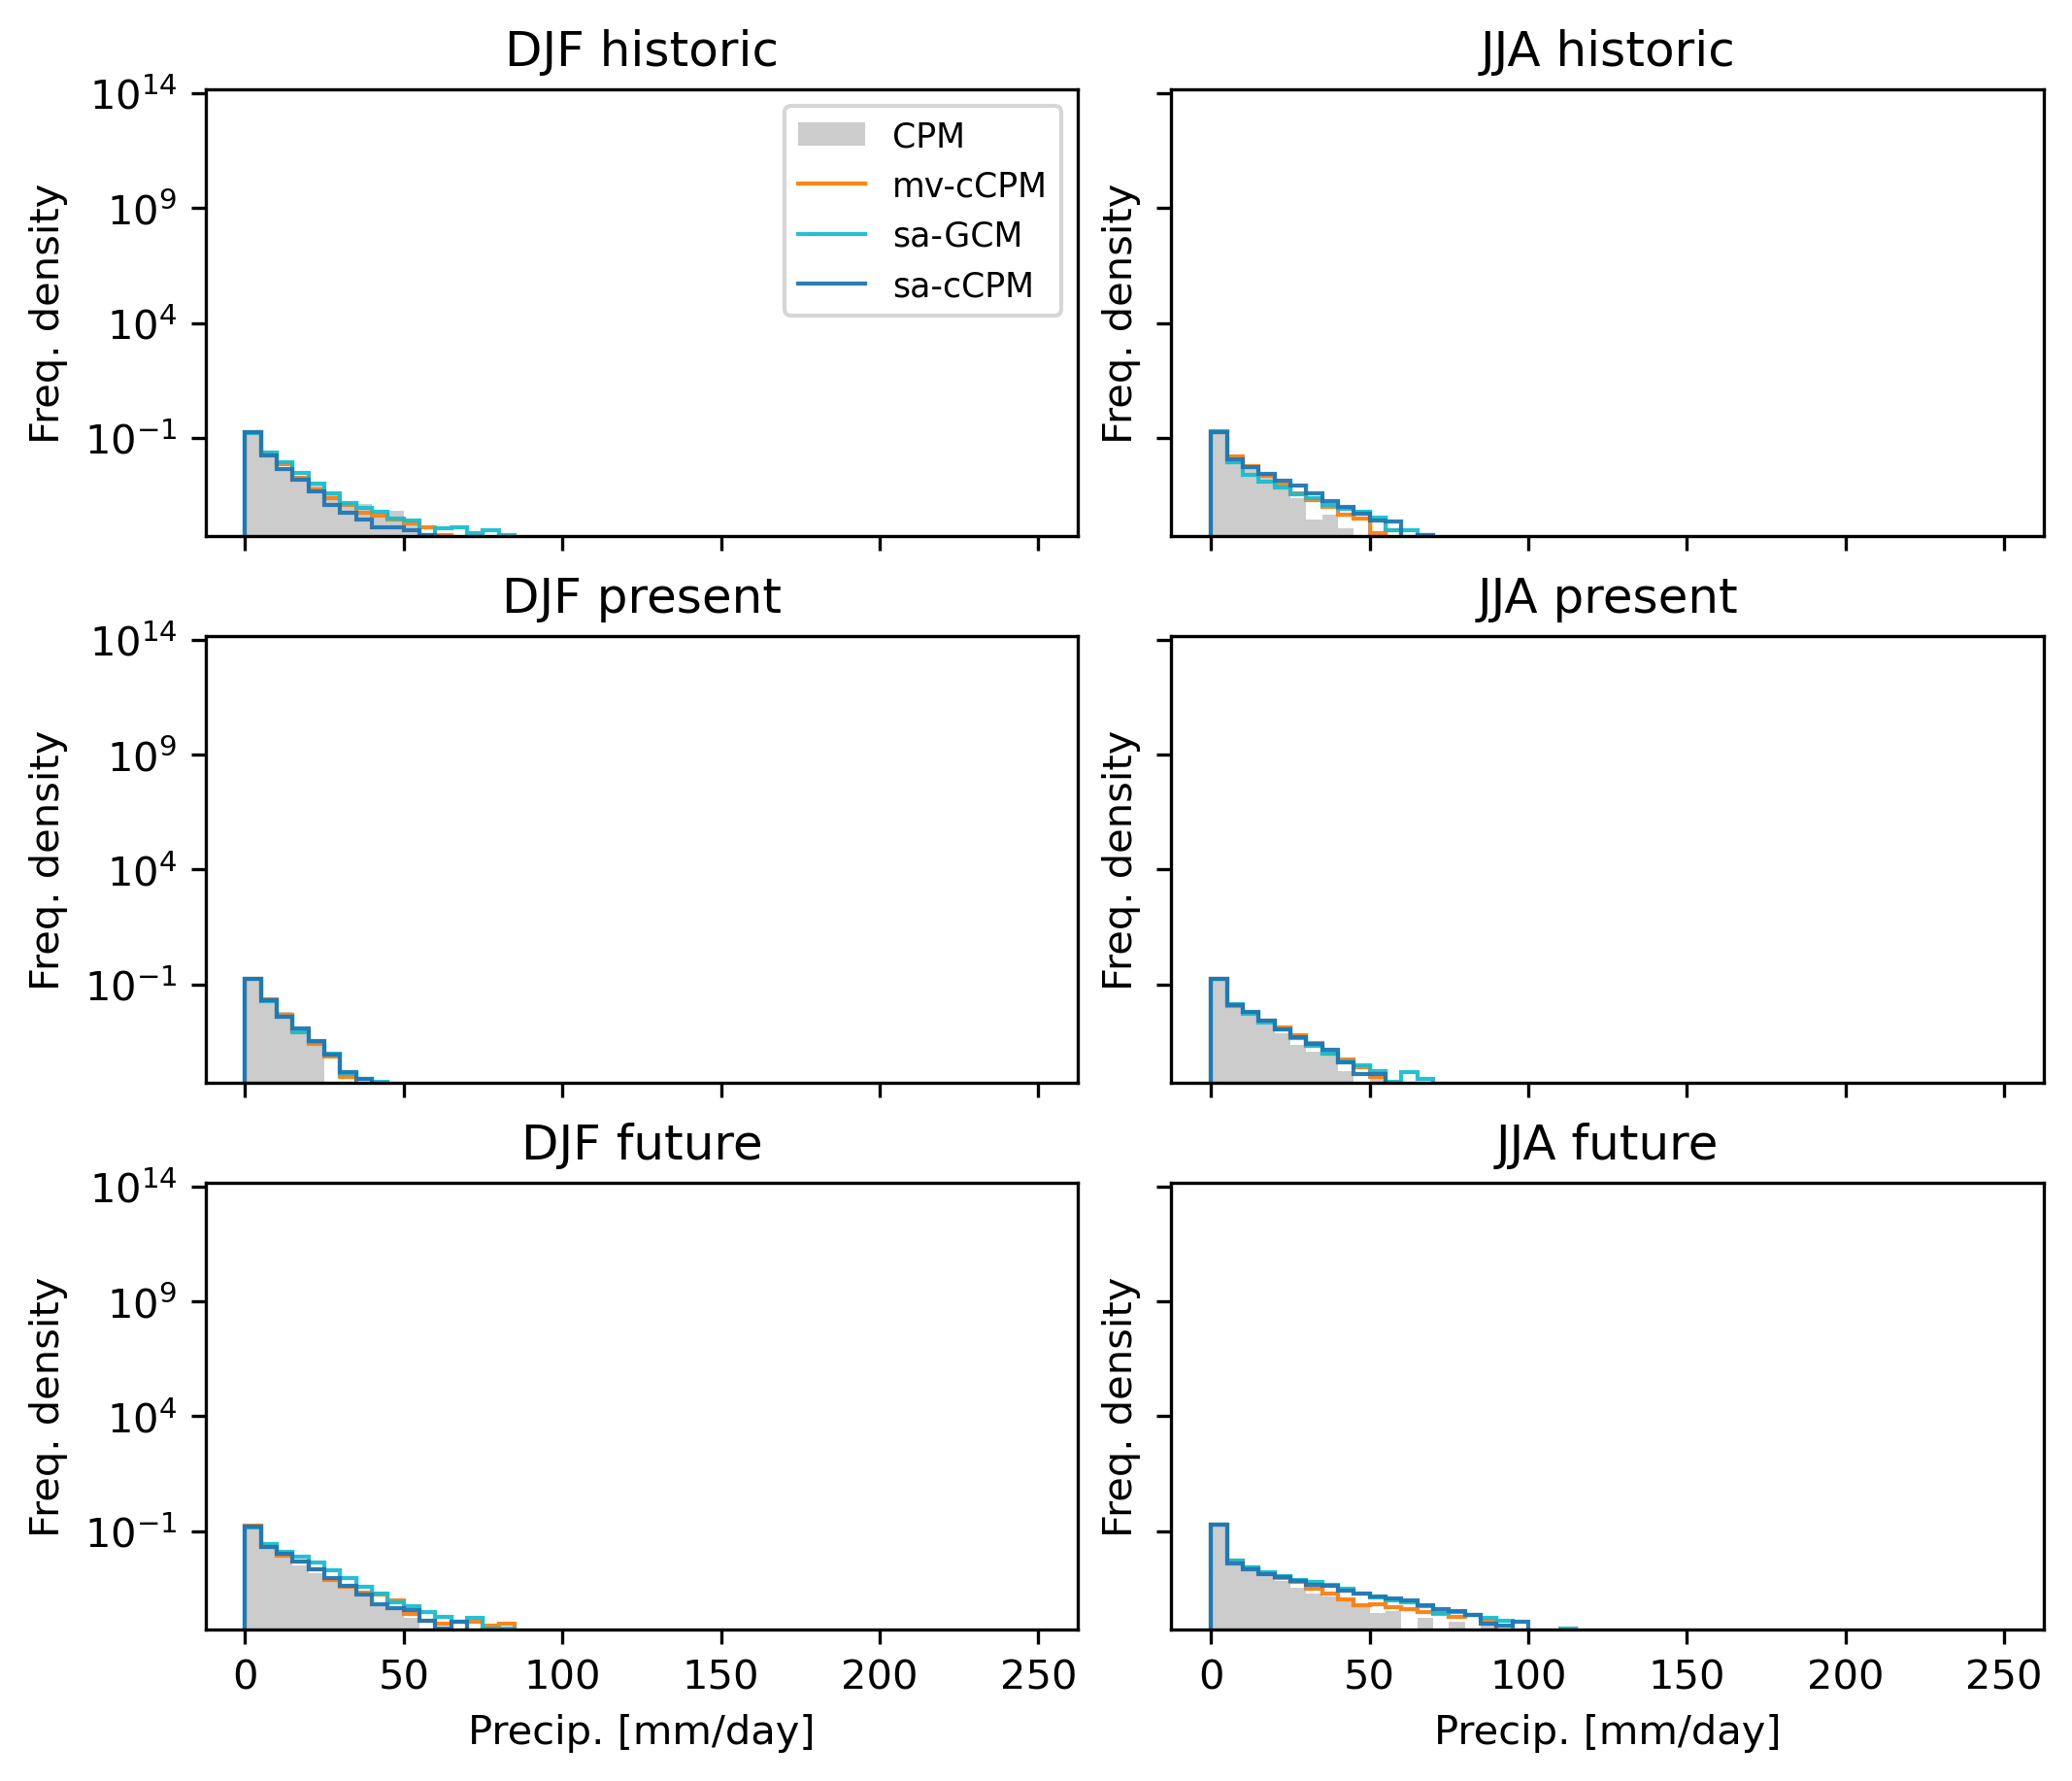

In [ ]:
for var in eval_vars:
    fig = plt.figure(layout='constrained', figsize=(3.5*len(CCS_SEASONS), 2*len(TIME_PERIODS)))
    dist_spec = np.array(list([[f"{season} {tp_key}" for season in CCS_SEASONS] for tp_key in TIME_PERIODS.keys() ]))
        
    spec = dist_spec
    
    axd = fig.subplot_mosaic(spec, sharex=True, sharey=True)#, gridspec_kw=dict(height_ratios=[3, 2, 2]), per_subplot_kw={ak: {"projection": cp_model_rotated_pole} for ak in meanb_axes_keys + stddevb_axes_keys})
    for season, seasonal_ccs_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue
        
        for tp_key, tp_ds in seasonal_ccs_ds.groupby("time_period"):
            ax = axd[f"{season} {tp_key}"]
            hist_data = [ dict(data=model_ds[f"pred_{var}"], label=model, color=MODELLABEL2SPEC[model]["color"]) for model, model_ds in tp_ds.groupby("model") ]
            hrange=VAR_RANGES[var]
            plot_freq_density(hist_data, ax=ax, target_da=tp_ds[f"target_{var}"], legend=(tp_key=="historic" and season=="DJF"), linewidth=1, title=f"{season} {tp_key}", hrange=hrange)
    
            ax.xaxis.label.set_visible(tp_key == "future")    
            
    plt.show()

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)


    metrics_ds = CCS_DS.groupby("time.season").map(lambda season_ds: season_ds.groupby("time_period").map(lambda tp_ds: compute_metrics(tp_ds[f"pred_{var}"], tp_ds[f"target_{var}"], thresholds=DIST_THRESHOLDS[var])))
        # IPython.display.display_markdown(f"#### {season}", raw=True)
        
    pretty_table(metrics_ds, round=4, dim_order=["season", "time_period", "model", "threshold"])

### pr

RMS Mean Bias (mm/day) 
 RMS Std Dev Bias (mm/day) 
 Relative RMS Mean Bias (%) 
 Relative RMS Std Dev Bias (%) 
 J-S distance 
 cpm_threshold_exceedence 
 emu_threshold_exceedence 
 threhold_exceedence_diff 
 
 
 season 
 time_period 
 model 
 threshold 
   
   
   
   
   
   
   
   
 
 
 
 
 DJF 
 future 
 mv-cCPM 
 0.100000 
 0.9000 
 1.7700 
 37.4500 
 53.3000 
 0.0602 
 0.5677 
 0.5615 
 -0.0062 
 
 
 25.000000 
 0.9000 
 1.7700 
 37.4500 
 53.3000 
 0.0602 
 0.0075 
 0.0083 
 0.0009 
 
 
 75.000000 
 0.9000 
 1.7700 
 37.4500 
 53.3000 
 0.0602 
 0.0000 
 0.0001 
 0.0001 
 
 
 125.000000 
 0.9000 
 1.7700 
 37.4500 
 53.3000 
 0.0602 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-GCM 
 0.100000 
 1.9300 
 2.9400 
 114.3200 
 115.6900 
 0.0881 
 0.5677 
 0.6419 
 0.0742 
 
 
 25.000000 
 1.9300 
 2.9400 
 114.3200 
 115.6900 
 0.0881 
 0.0075 
 0.0184 
 0.0110 
 
 
 75.000000 
 1.9300 
 2.9400 
 114.3200 
 115.6900 
 0.0881 
 0.0000 
 0.0001 
 0.0001 
 
 
 125.000000 
 1.9300 
 2.9400 
 114.3200 
 115.6900 
 0.0881 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-cCPM 
 0.100000 
 1.2000 
 2.0700 
 53.3800 
 71.7400 
 0.0572 
 0.5677 
 0.5807 
 0.0130 
 
 
 25.000000 
 1.2000 
 2.0700 
 53.3800 
 71.7400 
 0.0572 
 0.0075 
 0.0083 
 0.0009 
 
 
 75.000000 
 1.2000 
 2.0700 
 53.3800 
 71.7400 
 0.0572 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 1.2000 
 2.0700 
 53.3800 
 71.7400 
 0.0572 
 0.0000 
 0.0000 
 0.0000 
 
 
 historic 
 mv-cCPM 
 0.100000 
 0.7700 
 1.6400 
 405.3500 
 465.8800 
 0.0515 
 0.5740 
 0.6176 
 0.0436 
 
 
 25.000000 
 0.7700 
 1.6400 
 405.3500 
 465.8800 
 0.0515 
 0.0041 
 0.0025 
 -0.0016 
 
 
 75.000000 
 0.7700 
 1.6400 
 405.3500 
 465.8800 
 0.0515 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 0.7700 
 1.6400 
 405.3500 
 465.8800 
 0.0515 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-GCM 
 0.100000 
 1.1000 
 2.1100 
 793.6400 
 1071.1400 
 0.0771 
 0.5740 
 0.6126 
 0.0387 
 
 
 25.000000 
 1.1000 
 2.1100 
 793.6400 
 1071.1400 
 0.0771 
 0.0041 
 0.0039 
 -0.0002 
 
 
 75.000000 
 1.1000 
 2.1100 
 793.6400 
 1071.1400 
 0.0771 
 0.0000 
 0.0001 
 0.0001 
 
 
 125.000000 
 1.1000 
 2.1100 
 793.6400 
 1071.1400 
 0.0771 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-cCPM 
 0.100000 
 0.7400 
 1.3800 
 208.0700 
 276.1900 
 0.0378 
 0.5740 
 0.5837 
 0.0097 
 
 
 25.000000 
 0.7400 
 1.3800 
 208.0700 
 276.1900 
 0.0378 
 0.0041 
 0.0012 
 -0.0029 
 
 
 75.000000 
 0.7400 
 1.3800 
 208.0700 
 276.1900 
 0.0378 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 0.7400 
 1.3800 
 208.0700 
 276.1900 
 0.0378 
 0.0000 
 0.0000 
 0.0000 
 
 
 present 
 mv-cCPM 
 0.100000 
 0.8800 
 1.0700 
 38.8700 
 47.8200 
 0.0589 
 0.7514 
 0.6870 
 -0.0645 
 
 
 25.000000 
 0.8800 
 1.0700 
 38.8700 
 47.8200 
 0.0589 
 0.0000 
 0.0004 
 0.0004 
 
 
 75.000000 
 0.8800 
 1.0700 
 38.8700 
 47.8200 
 0.0589 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 0.8800 
 1.0700 
 38.8700 
 47.8200 
 0.0589 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-GCM 
 0.100000 
 0.9500 
 1.0200 
 34.7200 
 40.4500 
 0.0993 
 0.7514 
 0.6197 
 -0.1317 
 
 
 25.000000 
 0.9500 
 1.0200 
 34.7200 
 40.4500 
 0.0993 
 0.0000 
 0.0006 
 0.0006 
 
 
 75.000000 
 0.9500 
 1.0200 
 34.7200 
 40.4500 
 0.0993 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 0.9500 
 1.0200 
 34.7200 
 40.4500 
 0.0993 
 0.0000 
 0.0000 
 0.0000 
 
 
 sa-cCPM 
 0.100000 
 0.7600 
 1.0000 
 31.2400 
 46.7500 
 0.0583 
 0.7514 
 0.6895 
 -0.0619 
 
 
 25.000000 
 0.7600 
 1.0000 
 31.2400 
 46.7500 
 0.0583 
 0.0000 
 0.0006 
 0.0005 
 
 
 75.000000 
 0.7600 
 1.0000 
 31.2400 
 46.7500 
 0.0583 
 0.0000 
 0.0000 
 0.0000 
 
 
 125.000000 
 0.7600 
 1.0000 
 31.2400 
 46.7500 
 0.0583 
 0.0000 
 0.0000 
 0.0000 
 
 
 JJA 
 future 
 mv-cCPM 
 0.100000 
 1.1000 
 3.2800 
 25497.6191 
 73138.8203 
 0.0415 
 0.2227 
 0.2562 
 0.0336 
 
 
 25.000000 
 1.1000 
 3.2800 
 25497.6191 
 73138.8203 
 0.0415 
 0.0047 
 0.0075 
 0.0028 
 
 
 75.000000 
 1.1000 
 3.2800 
 25497.6191 
 73138.8203 
 0.0415 
 0.0001 
 0.0003 

### Subdomains

### pr

Target max: 27.093730926513672
sa-cCPM max: 30.847976684570312
mv-cCPM max: 45.064598083496094
sa-GCM max: 42.03547668457031
0.00014467592592592592
5e-05
Target max: 58.29104232788086
sa-cCPM max: 81.28704071044922
mv-cCPM max: 45.72764587402344
sa-GCM max: 75.72802734375
0.00014467592592592592
5e-05


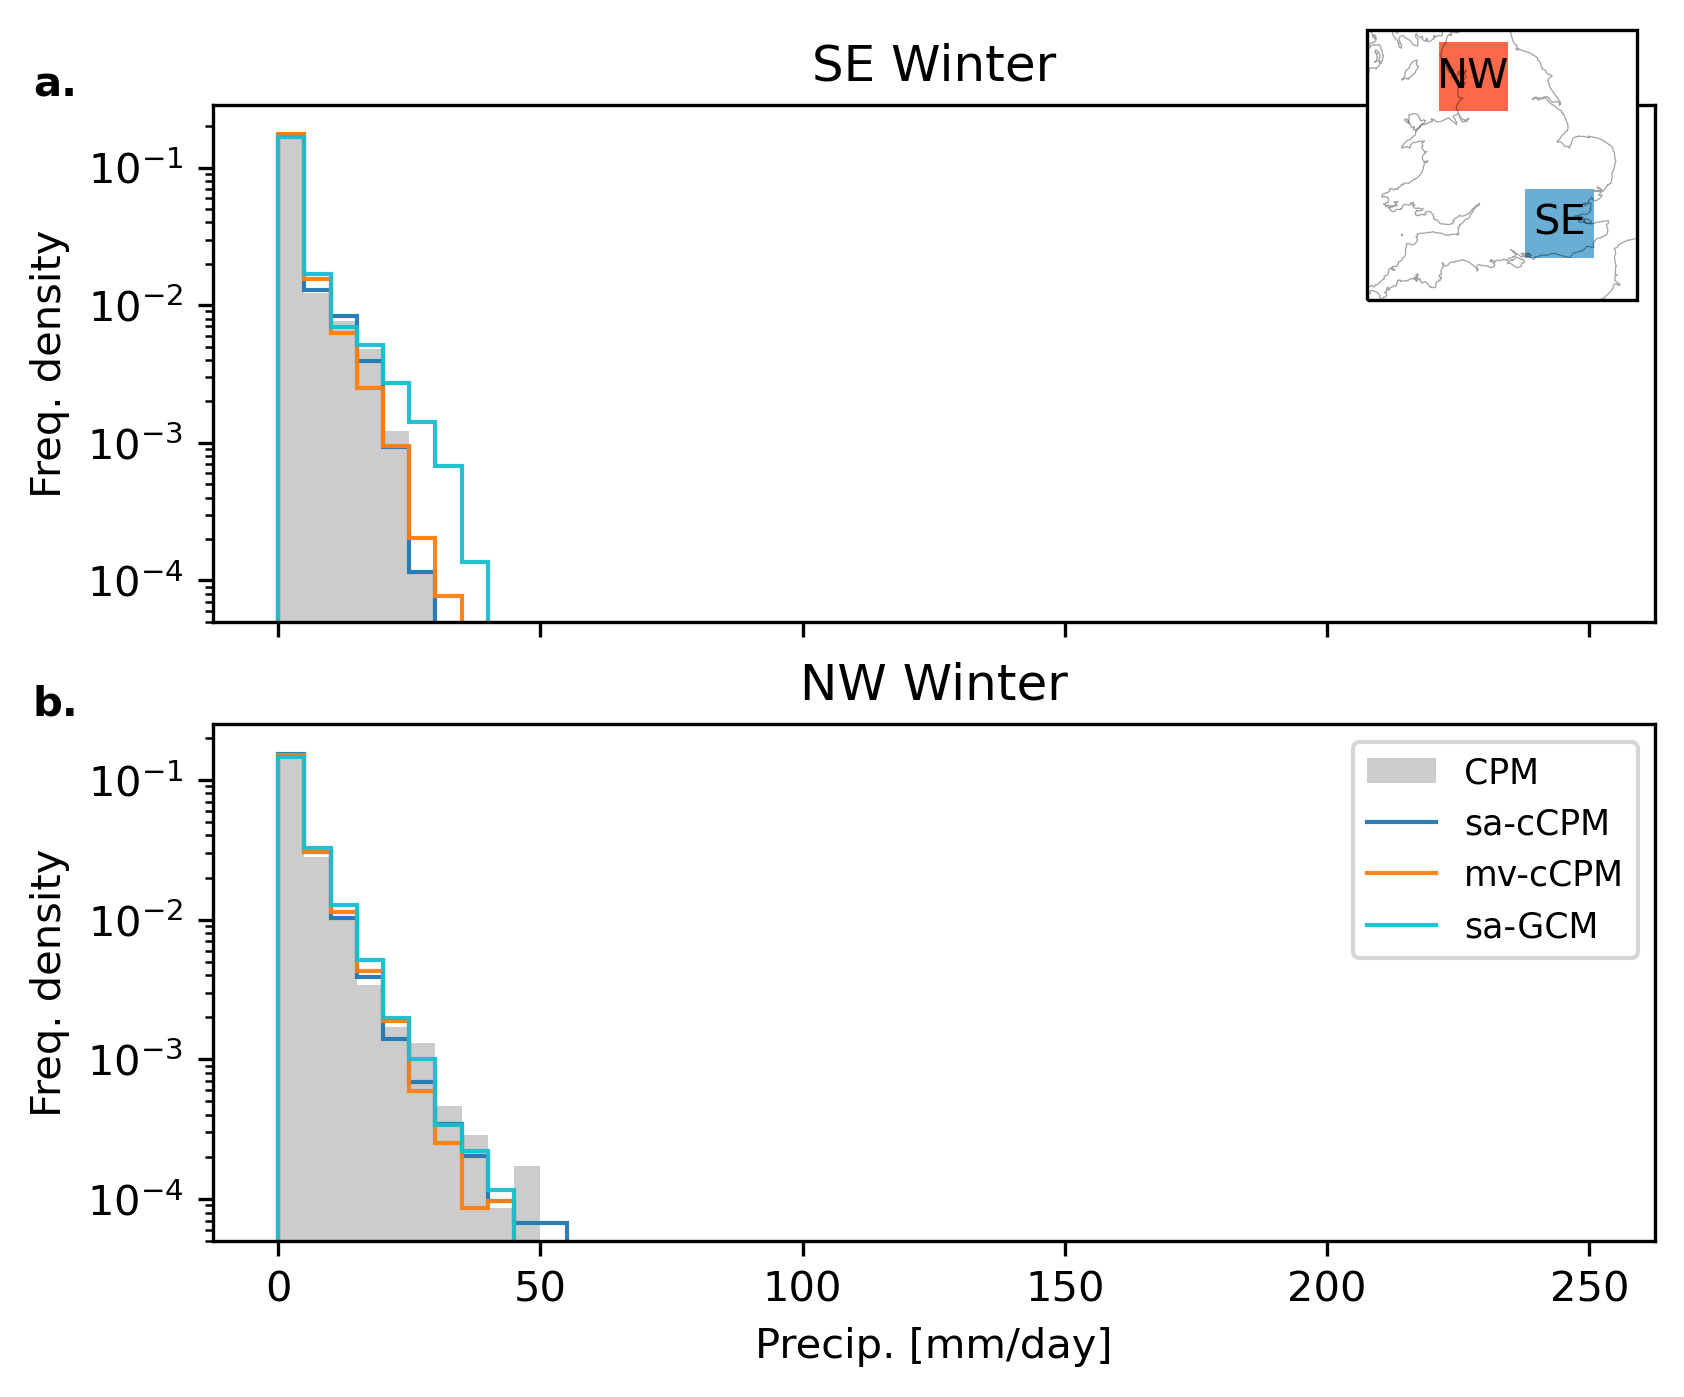

Target max: 24.437604904174805
sa-cCPM max: 58.30379104614258
mv-cCPM max: 47.88471984863281
sa-GCM max: 60.390174865722656
0.00014467592592592592
5e-05
Target max: 71.78972625732422
sa-cCPM max: 71.02454376220703
mv-cCPM max: 50.78374481201172
sa-GCM max: 112.03742980957031
0.00014467592592592592
5e-05


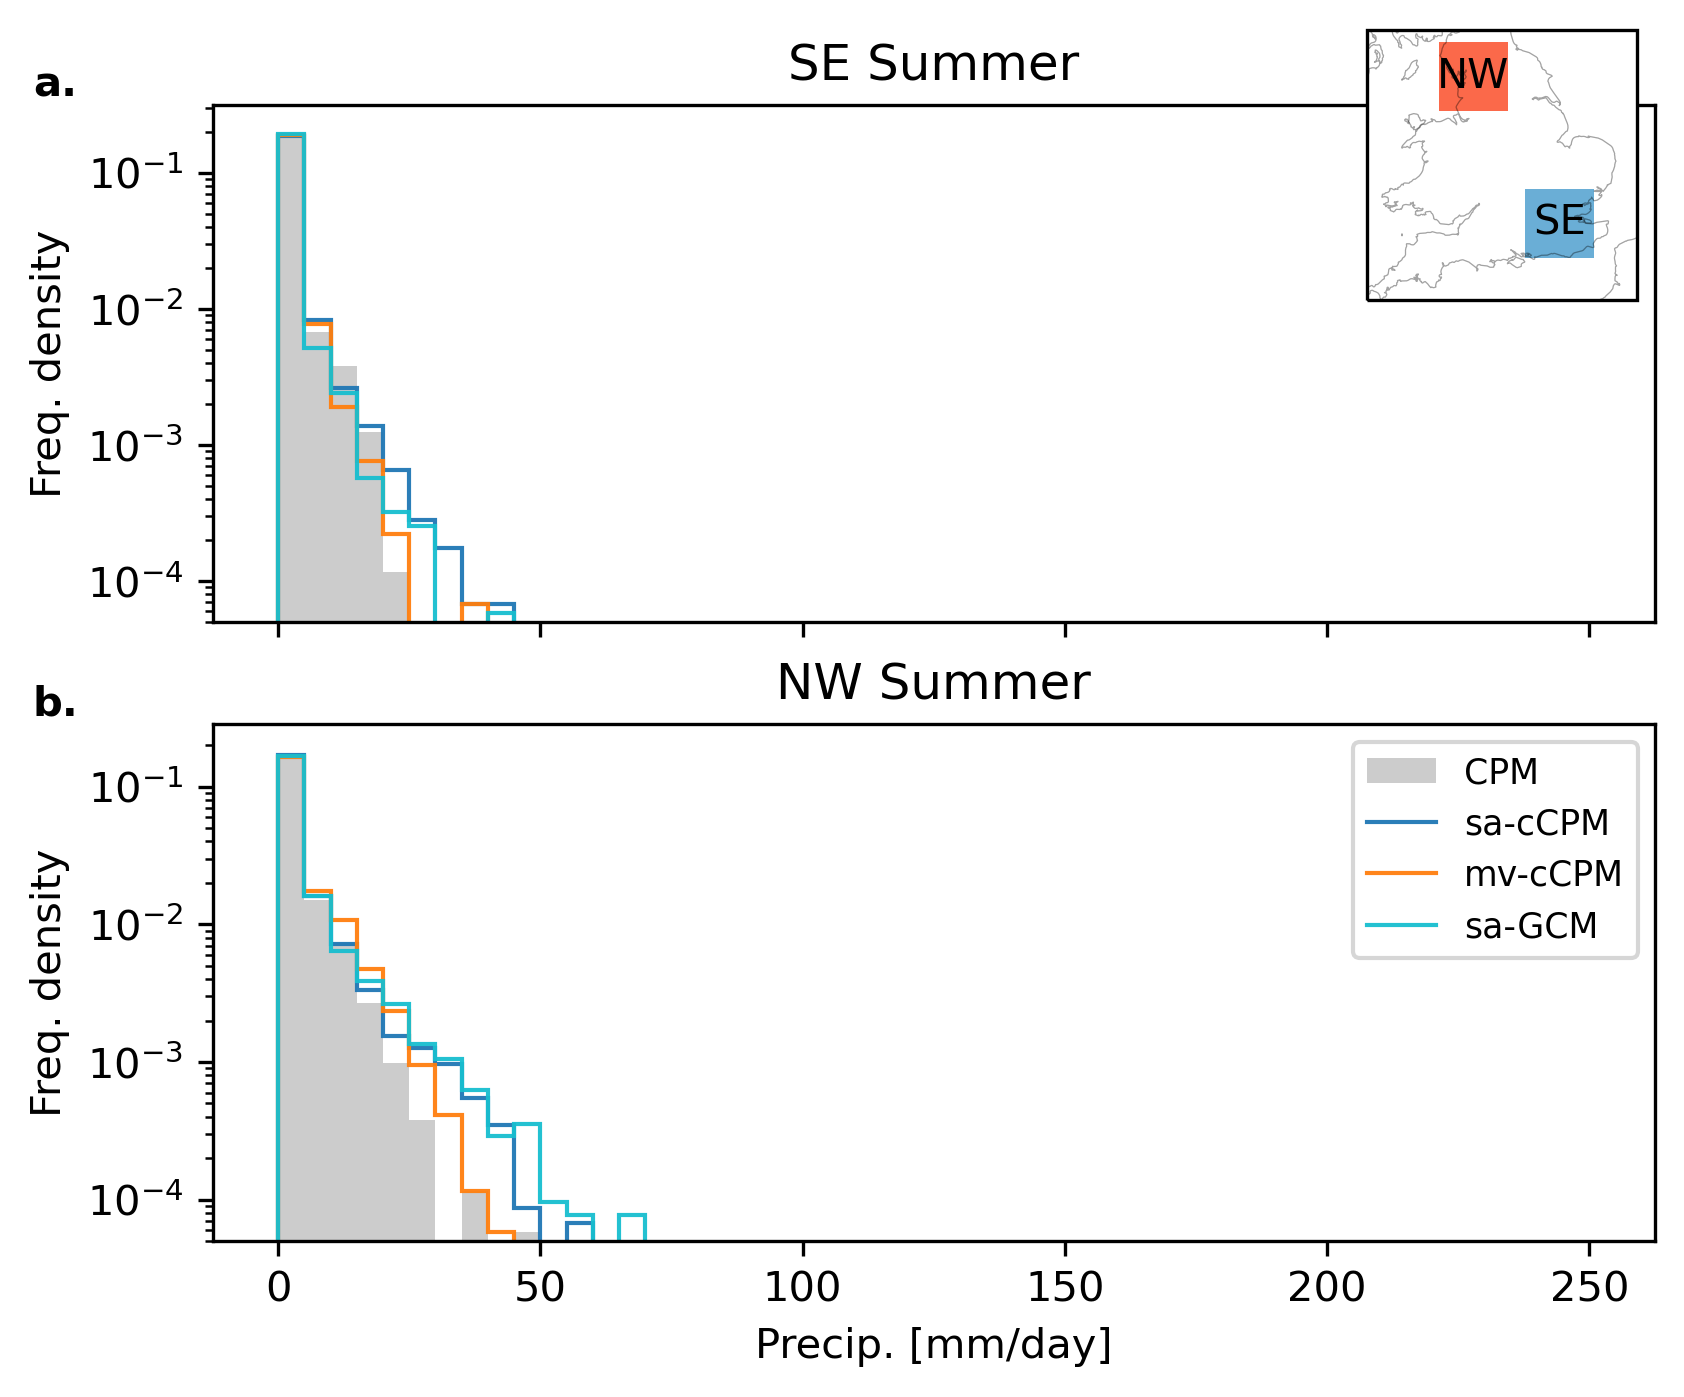

In [ ]:
for var in eval_vars:
    IPython.display.display_markdown(f"### {var}", raw=True)


    for season, seasonal_ccs_ds in CCS_DS.groupby("time.season"):
        if season not in CCS_SEASONS:
            continue

        fd_fig = plt.figure(figsize=(5.5, 4.5), layout="constrained")

        human_names = {
            "DJF": "Winter",
            "JJA": "Summer",
        }
    
        axd = fd_fig.subplot_mosaic(np.array(list(SUBREGIONS.keys())).reshape(-1, 1), sharex=True)
        
        for i, (srname, srdefn) in enumerate(SUBREGIONS.items()):

            srseason_cpm_da = seasonal_ccs_ds[f"target_{var}"].isel(**SUBREGIONS[srname])
    
            srseason_hist_data = [
                dict(data=seasonal_ccs_ds[f"pred_{var}"].sel(model=model).isel(**SUBREGIONS[srname]), label=model, color=spec["color"]) for source, mconfigs in MODELS.items() for model, spec in mconfigs.items()
            ]

            ax = axd[srname]
            if var == "pr":
                kwargs = {
                    "yscale": "log",
                }
            else:
                kwargs = {
                    "yscale": "linear",
                }
            plot_freq_density(srseason_hist_data, ax=ax, target_da=srseason_cpm_da, linewidth=1, hrange=VAR_RANGES[var], **kwargs)
            ax.set_title(f"{srname} {human_names[season]}")

            if i == 0:
                ax.set_xlabel("")
                ax.get_legend().remove()
                reg_ax = fd_fig.add_axes([0.8, 0.8, 0.2, 0.2], projection=cp_model_rotated_pole)
                # reg_ax = fd_fig.subplots(1, subplot_kw = dict(projection=cp_model_rotated_pole))
                nw_cpm_da = CPM_DAS[var].isel(**SUBREGIONS["NW"])
                se_cpm_da = CPM_DAS[var].isel(**SUBREGIONS["SE"])
                plot_map(10*xr.ones_like(nw_cpm_da.isel(ensemble_member=0, time=0)), ax=reg_ax, style=None, cmap="Reds", cl_kwargs=dict(alpha=0.2))
                plot_map(1*xr.ones_like(se_cpm_da.isel(ensemble_member=0, time=0)), ax=reg_ax, style=None, cmap="Blues", cl_kwargs=dict(alpha=0.2))
                reg_ax.annotate("NW", xy=(nw_cpm_da.grid_longitude.mean().values.item(), nw_cpm_da.grid_latitude.mean().values.item()), xycoords="data", fontsize="medium", ha="center", va="center")
                reg_ax.annotate("SE", xy=(se_cpm_da.grid_longitude.mean().values.item(), se_cpm_da.grid_latitude.mean().values.item()), xycoords="data", fontsize="medium", ha="center", va="center")
                reg_ax.set_extent([-2, 3, -2.5, 2.5], crs=cp_model_rotated_pole)
    

            ax.annotate(f"{string.ascii_lowercase[i]}.", xy=(0.02, 1.0), xycoords=("figure fraction", "axes fraction"), weight='bold', ha="left", va="bottom")

        plt.show()